In [ ]:
from astropy.io import fits
from astropy.timeseries import TimeSeries
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter
import pandas as pd
from astroquery.mast import Observations
import glob

In [ ]:
obs_table = Observations.query_criteria(
    obs_collection="Kepler",
    dataproduct_type="timeseries",
    project="Kepler"
)

print("Total Kepler light curves:", len(obs_table))

# Pick a subset to start (e.g., first 5)
products = Observations.get_product_list(obs_table[:5])
manifest = Observations.download_products(
    products,
    productSubGroupDescription="LC",  # LC = long cadence
    mrp_only=True
)

In [20]:
hdul = fits.open("../data/kplr011446443-2009131110544_slc.fits")
data = hdul[1].data
#print(data.columns.names)

time = data['TIME']
flux = data['PDCSAP_FLUX']
quality = data['SAP_QUALITY']

In [48]:
BAD_BITS = (1<<1) | (1<<2) | (1<<3) | (1<<4) | (1<<5) | (1<<7)
mask = (~np.isnan(time)) & (~np.isnan(flux)) & ((quality & BAD_BITS) == 0)

time_clean = time[mask]
flux_clean = flux[mask]
mask_window = (time_clean > 120) & (time_clean < 130)
flux_norm = flux_clean / np.median(flux_clean)
flux_smooth = savgol_filter(flux_norm, 101, 2) 


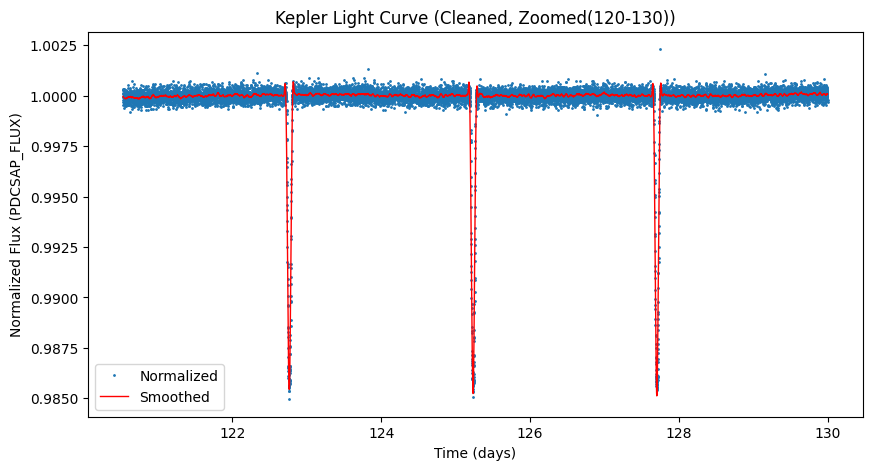

In [49]:
plt.figure(figsize=(10,5))
plt.plot(time_clean[mask_window], flux_norm[mask_window], ".", markersize=2, label="Normalized")
plt.plot(time_clean[mask_window], flux_smooth[mask_window], "r-", linewidth=1, label="Smoothed")
plt.xlabel("Time (days)")
plt.ylabel("Normalized Flux (PDCSAP_FLUX)")
plt.title("Kepler Light Curve (Cleaned, Zoomed(120-130))")
plt.legend()
plt.show()


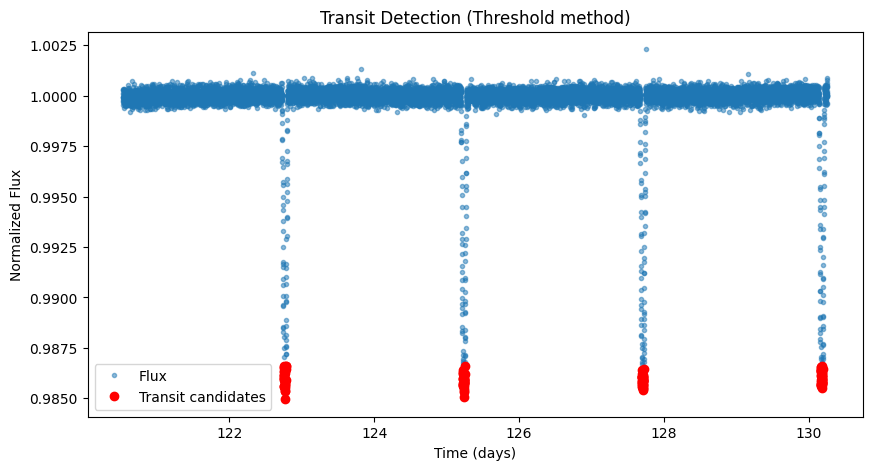

In [55]:
threshold = np.percentile(flux_norm, 1)   # bottom 1%
dip_mask = flux_norm < threshold

plt.figure(figsize=(10,5))
plt.plot(time_clean, flux_norm, ".", alpha=0.5, label="Flux")
plt.plot(time_clean[dip_mask], flux_norm[dip_mask], "ro", label="Transit candidates")
plt.xlabel("Time (days)")
plt.ylabel("Normalized Flux")
plt.title("Transit Detection (Threshold method)")
plt.legend()
plt.show()


Text(0.5, 1.0, 'Phase-Folded Light Curve')

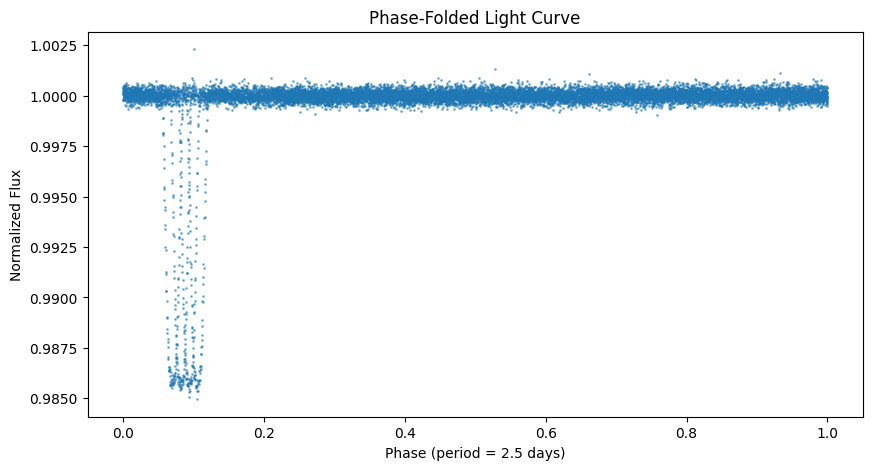

In [59]:
period = 2.5
phase = (time_clean % period) / period

plt.figure(figsize=(10,5))
plt.plot(phase, flux_norm, ".", markersize=2, alpha=0.5)
plt.xlabel("Phase (period = 2.5 days)")
plt.ylabel("Normalized Flux")
plt.title("Phase-Folded Light Curve")

In [ ]:
dip_indices = np.where(dip_mask)[0]

# Extract features for dip points (potential transits)
transit_features = []

for idx in dip_indices:
    dip_time = time_clean[idx]
    dip_depth = 1.0 - flux_norm[idx]
    local_window = flux_norm[max(0, idx-10): idx+10]  # Larger window
    noise = np.std(local_window) if len(local_window) > 0 else 0
    
    # Add more distinguishing features
    duration = 1  # Calculate actual duration
    while idx+duration < len(flux_norm) and flux_norm[idx+duration] < threshold:
        duration += 1
    
    transit_features.append([dip_depth, noise, duration])

# Extract features for non-transit points (random baseline points)
non_transit_features = []
normal_indices = np.where(~dip_mask)[0]
normal_sample = np.random.choice(normal_indices, len(dip_indices), replace=False)

for idx in normal_sample:
    baseline_depth = 1.0 - flux_norm[idx]  # Should be close to 0
    local_window = flux_norm[max(0, idx-10): idx+10]
    noise = np.std(local_window) if len(local_window) > 0 else 0
    duration = 1  # Normal points have short "duration"
    
    non_transit_features.append([baseline_depth, noise, duration])

# Create balanced dataset
all_features = transit_features + non_transit_features
labels = [1] * len(transit_features) + [0] * len(non_transit_features)

df = pd.DataFrame(all_features, columns=["dip_depth", "local_noise", "duration"])
df["label"] = labels

print(f"Transit samples: {len(transit_features)}")
print(f"Non-transit samples: {len(non_transit_features)}")
print(df.label.value_counts())

Transit samples: 141
Non-transit samples: 141
label
1    141
0    141
Name: count, dtype: int64


In [74]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.utils import resample



X = df[["dip_depth", "local_noise", "duration"]]
y = df["label"]

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.99, random_state=42, stratify=y
)

# Train + CV
model = RandomForestClassifier(n_estimators=100, random_state=42)
scores = cross_val_score(model, X, y, cv=5)
print(f"Cross-validation accuracy: {scores.mean():.3f} ± {scores.std():.3f}")

# Fit & report
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


Cross-validation accuracy: 0.996 ± 0.007
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       140
           1       0.99      1.00      1.00       140

    accuracy                           1.00       280
   macro avg       1.00      1.00      1.00       280
weighted avg       1.00      1.00      1.00       280



In [348]:
#Neural Net

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.utils import resample

X = df[["dip_depth", "local_noise", "duration"]]
y = df["label"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=42,
    stratify=y
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



In [349]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(  optimizer='adam', 
                loss='binary_crossentropy',
                metrics=['accuracy'])

c:\Users\Pablo\OneDrive\School of life\Coding\Codigo\Python\practice1\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [350]:
history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=20,
                    batch_size=16,
                    verbose=0)

In [351]:
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {acc:.3f}")

y_pred = (model.predict(X_test) > 0.5).astype("int32")

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

Test accuracy: 0.988
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        43
           1       0.98      1.00      0.99        42

    accuracy                           0.99        85
   macro avg       0.99      0.99      0.99        85
weighted avg       0.99      0.99      0.99        85



In [352]:
print(f"Total data points after quality filtering: {len(time_clean)}")
print(f"Points below threshold (1st percentile): {np.sum(dip_mask)}")

Total data points after quality filtering: 14034
Points below threshold (1st percentile): 141
